### Prediction model for DAENERGY

In [932]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from src.process_data import pivot_data, create_index, clean_data

#### Loading and cleaning data

- Pivot table
- It's considered data from 2017-07-05 to 2017-10-30
- There are some missing values. Those values where computed using replicating the value of the previous observation (To obtain an index with hourly frequency and obtain forecasts using stats models.
- It's created the index with TRADEDATE and HOUROFWEEK. Finally we obtain the exact date and time of trade.


In [936]:
df = pivot_data('data/Data.txt')
df = clean_data(df)
df = create_index(df)

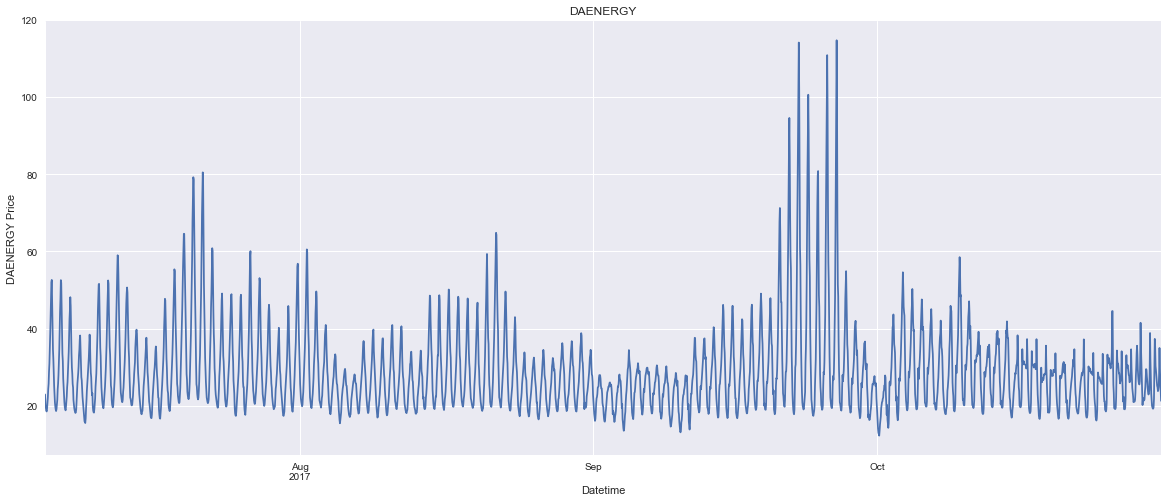

In [937]:
plt.figure(figsize=(20,8))
df.DAENERGY.plot()
plt.title('DAENERGY')
plt.xlabel('Datetime')
plt.ylabel('DAENERGY Price');

In [938]:
df.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,2017-07-05,73,67,63,66,77,83,70,80,69,...,81,67,68,70,78515,22.89,22.06,4576.170,14310,01:00:00
2017-07-05 02:00:00,2017-07-05,74,63,62,67,81,84,69,84,63,...,80,68,61,66,68721,20.17,19.97,2952.209,13300,02:00:00
2017-07-05 03:00:00,2017-07-05,75,62,62,66,80,82,69,82,62,...,79,68,61,65,65820,19.42,19.41,2791.408,13300,03:00:00
2017-07-05 04:00:00,2017-07-05,76,61,62,66,78,80,69,80,61,...,78,67,60,64,64262,18.74,19.09,2525.984,13300,04:00:00
2017-07-05 05:00:00,2017-07-05,77,59,61,66,75,79,68,80,60,...,77,67,59,64,64020,18.49,18.64,2520.608,13300,05:00:00


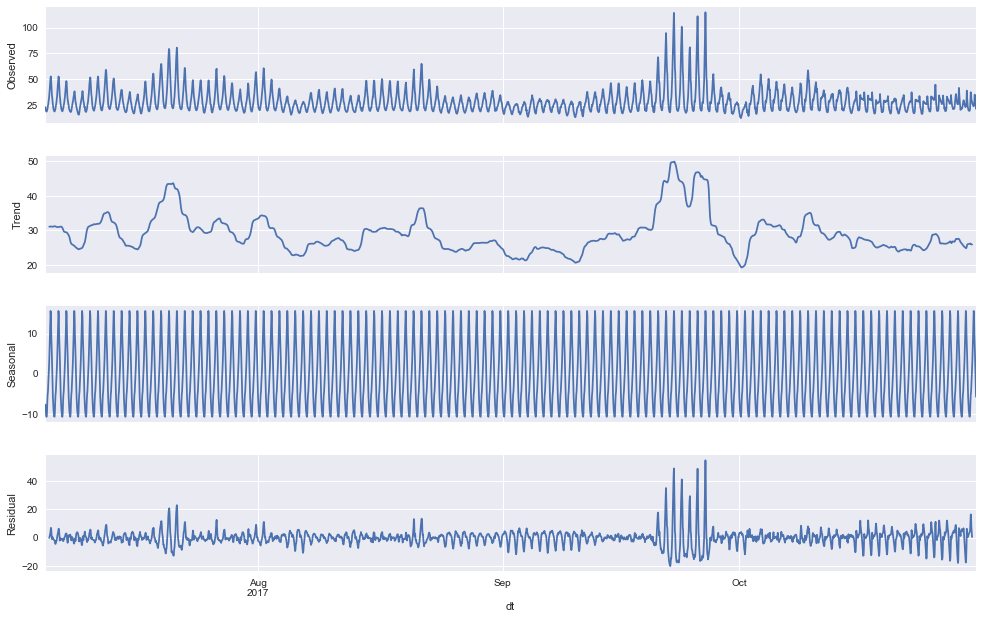

In [939]:
decomposition = seasonal_decompose(df.DAENERGY, freq = 24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

In [943]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=24)
    #rolstd = pd.rolling_std(timeseries, window=24)
    rolmean = pd.Series.rolling(timeseries, window=24, center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=24, center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

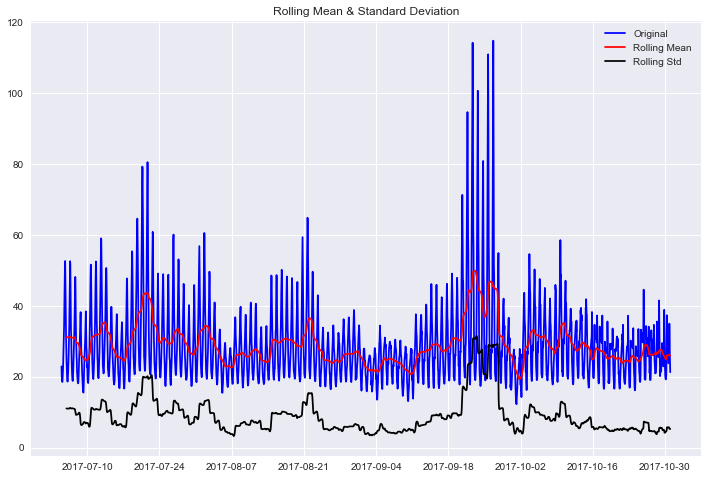

Results of Dickey-Fuller Test:
Test Statistic                   -3.517626
p-value                           0.007546
#Lags Used                       26.000000
Number of Observations Used    2805.000000
Critical Value (1%)              -3.432683
Critical Value (5%)              -2.862571
Critical Value (10%)             -2.567319
dtype: float64


In [944]:
test_stationarity(df.DAENERGY)

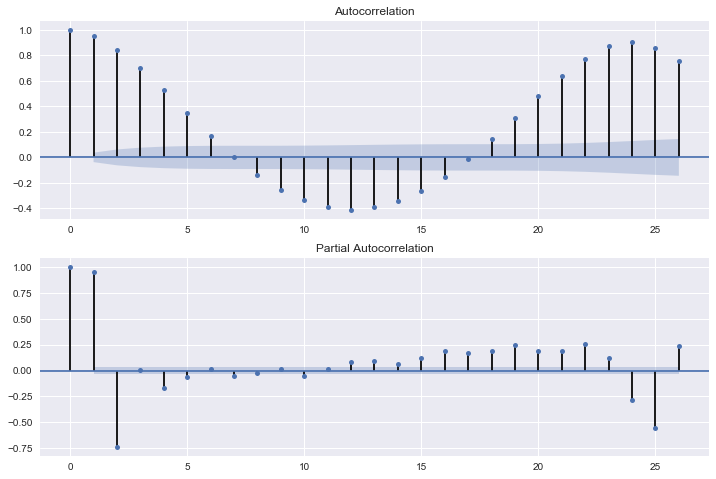

In [948]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.DAENERGY.iloc[25:], lags=26, ax=ax1, alpha = 0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.DAENERGY.iloc[25:], lags=26, ax=ax2,alpha = 0.05)

In [766]:
def create_model(dd, date_predict, exogens):
    mod = sm.tsa.statespace.SARIMAX(dd.DAENERGY,exogen = dd[exogens], trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
    results = mod.fit()
    print (results.summary())
    pred = results.forecast(24)
    real = df[date_predict].DAENERGY
    RMSE=get_rmse(pred,real)
    plt.plot(df[date_predict].index, real,'g',pred.index,pred,'r' )
    plt.title('RMSE = {:.2f}'.format(RMSE))
    plt.xlabel('time')
    plt.ylabel('Price DAENERGY')
    
    return results, mod

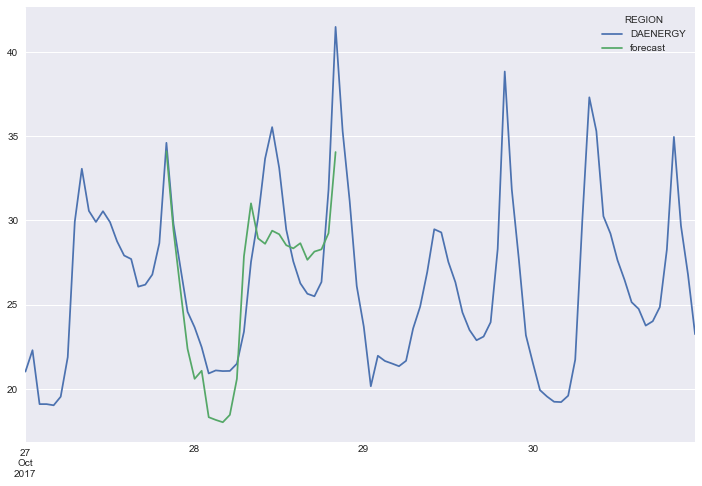

In [537]:
df['forecast'] = results.predict(start = 2755, end= 2755+24, dynamic= True)  
df['2017-10-27':'2017-10-30'][['DAENERGY', 'forecast']].plot(figsize=(12, 8)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [586]:
mod = sm.tsa.statespace.SARIMAX(df[:'2017-10-26'].DAENERGY, trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 2735
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -5100.816
Date:                            Sun, 05 Nov 2017   AIC                          10207.631
Time:                                    20:42:37   BIC                          10225.373
Sample:                                07-05-2017   HQIC                         10214.043
                                     - 10-26-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.7312      0.010     72.318      0.000       0.711       0.751
ma.S.L24      -0.9624      0.006   

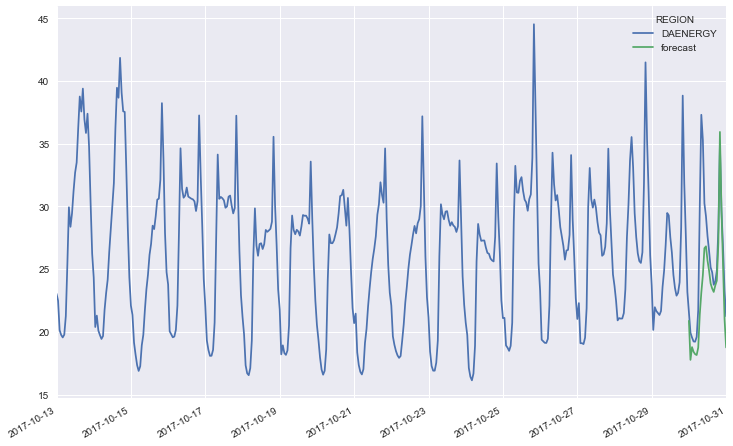

In [538]:
df['forecast'] = results.predict(start = df.shape[0]-25, end= df.shape[0]-1, dynamic= True)  
df['2017-10-13':][['DAENERGY', 'forecast']].plot(figsize=(12, 8)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [488]:
start = datetime.datetime.strptime("2017-10-15", "%Y-%m-%d")
date_list = [start + relativedelta(hours=x) for x in range(0,25)]
future = pd.DataFrame(index=date_list, columns= df.columns)
future=future[future.index>'2017-10-15']
df = pd.concat([df, future])

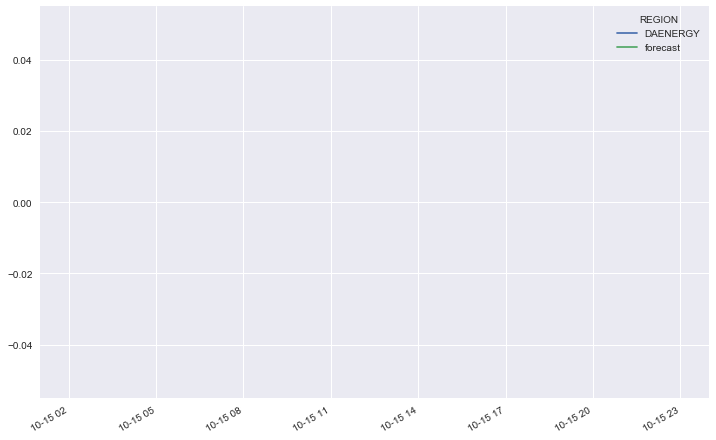

In [489]:
df['forecast'] = results.predict(start = df.shape[0]-25, end= df.shape[0]-1, dynamic= True)  
df[['DAENERGY', 'forecast']].iloc[-48:].plot(figsize=(12, 8)) 

In [481]:
future.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday,forecast
2017-10-15 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-15 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-15 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-15 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [540]:
df.index.freq = 'h' 

In [708]:
results.forecast(24)

2017-10-31 01:00:00    19.582971
2017-10-31 02:00:00    18.994580
2017-10-31 03:00:00    18.624271
2017-10-31 04:00:00    18.536582
2017-10-31 05:00:00    18.870093
2017-10-31 06:00:00    20.829552
2017-10-31 07:00:00    28.205717
2017-10-31 08:00:00    34.542632
2017-10-31 09:00:00    32.901205
2017-10-31 10:00:00    29.274695
2017-10-31 11:00:00    28.759237
2017-10-31 12:00:00    27.712461
2017-10-31 13:00:00    26.914260
2017-10-31 14:00:00    26.210121
2017-10-31 15:00:00    26.252872
2017-10-31 16:00:00    25.675429
2017-10-31 17:00:00    26.202837
2017-10-31 18:00:00    26.614707
2017-10-31 19:00:00    29.001609
2017-10-31 20:00:00    35.010662
2017-10-31 21:00:00    30.072586
2017-10-31 22:00:00    26.683065
2017-10-31 23:00:00    23.024783
2017-11-01 00:00:00    21.022259
Freq: H, dtype: float64

In [358]:
results.forecast?

In [362]:
results.forecasts.shape

(1, 2446)

In [363]:
df.shape

(2446, 143)

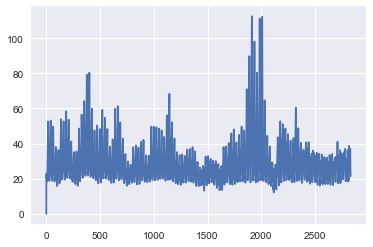

In [712]:
plt.plot(results.forecasts.reshape(df.shape[0],1));

In [713]:
results.forecast(24)

2017-10-31 01:00:00    19.582971
2017-10-31 02:00:00    18.994580
2017-10-31 03:00:00    18.624271
2017-10-31 04:00:00    18.536582
2017-10-31 05:00:00    18.870093
2017-10-31 06:00:00    20.829552
2017-10-31 07:00:00    28.205717
2017-10-31 08:00:00    34.542632
2017-10-31 09:00:00    32.901205
2017-10-31 10:00:00    29.274695
2017-10-31 11:00:00    28.759237
2017-10-31 12:00:00    27.712461
2017-10-31 13:00:00    26.914260
2017-10-31 14:00:00    26.210121
2017-10-31 15:00:00    26.252872
2017-10-31 16:00:00    25.675429
2017-10-31 17:00:00    26.202837
2017-10-31 18:00:00    26.614707
2017-10-31 19:00:00    29.001609
2017-10-31 20:00:00    35.010662
2017-10-31 21:00:00    30.072586
2017-10-31 22:00:00    26.683065
2017-10-31 23:00:00    23.024783
2017-11-01 00:00:00    21.022259
Freq: H, dtype: float64

In [741]:
def check_bad_data(df):
    temp = df.groupby('TRADEDATE').count()['HOUROFWEEK']
    temp[temp<24]
    df[df['TRADEDATE'] == '2017-10-25']
    

In [645]:
RMSE = np.sqrt((results.forecasts_error**2).sum()/df.shape[0])

In [717]:
RMSE

1.657343300467107

In [719]:
sm.tsa.statespace.SARIMAX?

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 1007
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -1510.882
Date:                            Sun, 05 Nov 2017   AIC                           3027.763
Time:                                    22:20:36   BIC                           3042.508
Sample:                                07-05-2017   HQIC                          3033.365
                                     - 08-15-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6273      0.023     27.832      0.000       0.583       0.672
ma.S.L24      -0.9980      0.411   

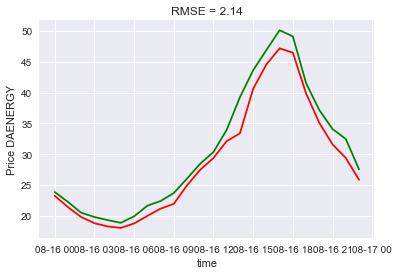

In [772]:
res, mod = create_model(df[:'2017-08-15'],'2017-08-16',temps)

In [786]:
fcast = res.get_forecast(24)

In [787]:
fcast_ci= fcast.conf_int(alpha=0.25)

In [830]:
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci.loc['2017-07-05':]
predict_ci['upper DAENERGY'] = predict_ci['upper DAENERGY'].apply(lambda x: 30 if x>100 else x)
predict_ci['lower DAENERGY'] = predict_ci['lower DAENERGY'].apply(lambda x: 0 if x<0 else x)
predict_ci

,lower DAENERGY,upper DAENERGY
2017-07-05 01:00:00,0.000000,30.000000
2017-07-05 02:00:00,0.000000,30.000000
2017-07-05 03:00:00,0.000000,30.000000
2017-07-05 04:00:00,0.000000,30.000000
2017-07-05 05:00:00,0.000000,30.000000
2017-07-05 06:00:00,0.000000,30.000000
2017-07-05 07:00:00,0.000000,30.000000
2017-07-05 08:00:00,0.000000,30.000000
2017-07-05 09:00:00,0.000000,30.000000
2017-07-05 10:00:00,0.000000,30.000000


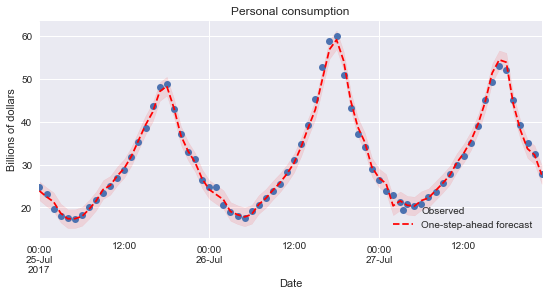

In [832]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
df.loc['2017-07-25':'2017-07-27', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2017-07-25':'2017-07-27'].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2017-07-25':'2017-07-27']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

In [818]:
ci.iloc[:,0]

2017-07-05 01:00:00   -2771.808670
2017-07-05 02:00:00   -1937.075429
2017-07-05 03:00:00   -1939.795429
2017-07-05 04:00:00   -1940.545429
2017-07-05 05:00:00   -1941.225429
2017-07-05 06:00:00   -1941.475429
2017-07-05 07:00:00   -1940.765429
2017-07-05 08:00:00   -1939.425429
2017-07-05 09:00:00   -1937.875429
2017-07-05 10:00:00   -1935.635429
2017-07-05 11:00:00   -1934.305429
2017-07-05 12:00:00   -1931.135429
2017-07-05 13:00:00   -1929.075429
2017-07-05 14:00:00   -1925.595429
2017-07-05 15:00:00   -1921.445429
2017-07-05 16:00:00   -1916.645429
2017-07-05 17:00:00   -1913.125429
2017-07-05 18:00:00   -1907.985429
2017-07-05 19:00:00   -1907.345429
2017-07-05 20:00:00   -1913.195429
2017-07-05 21:00:00   -1919.555429
2017-07-05 22:00:00   -1925.435429
2017-07-05 23:00:00   -1927.895429
2017-07-06 00:00:00   -1931.675429
2017-07-06 01:00:00   -1349.320992
2017-07-06 02:00:00      17.900292
2017-07-06 03:00:00      17.650291
2017-07-06 04:00:00      16.630291
2017-07-06 05:00:00 

In [751]:
pred = res.forecast(24)
real = df['2017-08-16'].DAENERGY


In [752]:
def get_rmse(pred, real):
    return np.sqrt(((pred-real)**2).sum()/(pred.shape[0]))

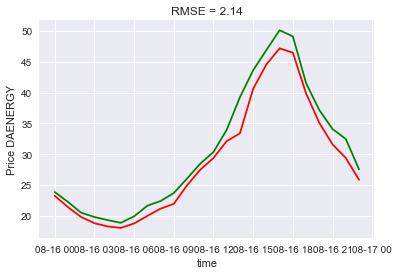

In [754]:
RMSE=get_rmse(pred,real)

plt.plot(df['2017-08-16'].index, real,'g',pred.index,pred,'r' )
plt.title('RMSE = {:.2f}'.format(RMSE))
plt.xlabel('time')
plt.ylabel('Price DAENERGY')

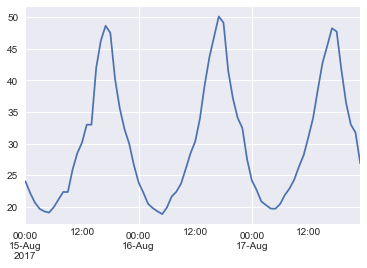

In [756]:
df['2017-08-15':'2017-08-17']['DAENERGY'].plot()

In [771]:
mod = sm.tsa.statespace.SARIMAX(df.DAENERGY,trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 2832
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -5291.634
Date:                            Sun, 05 Nov 2017   AIC                          10589.268
Time:                                    22:06:11   BIC                          10607.114
Sample:                                07-05-2017   HQIC                         10595.706
                                     - 10-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6984      0.012     58.061      0.000       0.675       0.722
ma.S.L24      -0.9344      0.007   

In [763]:
temps = []
for col in df.columns.values:
    if len(col)==4:
        temps.append(col)

In [764]:
temps

['CYWG',
 'K2G4',
 'KABE',
 'KABI',
 'KACT',
 'KACY',
 'KADS',
 'KAKR',
 'KAMA',
 'KANJ',
 'KAOO',
 'KARB',
 'KARR',
 'KATT',
 'KAUS',
 'KAVP',
 'KAWM',
 'KBAZ',
 'KBIS',
 'KBPT',
 'KBRO',
 'KBTR',
 'KBWI',
 'KCAK',
 'KCGI',
 'KCGX',
 'KCID',
 'KCKB',
 'KCLE',
 'KCLL',
 'KCMH',
 'KCMI',
 'KCOU',
 'KCRP',
 'KCRW',
 'KCVG',
 'KDAL',
 'KDAY',
 'KDBQ',
 'KDCA',
 'KDEC',
 'KDET',
 'KDFW',
 'KDLH',
 'KDMH',
 'KDOV',
 'KDSM',
 'KDTO',
 'KDTW',
 'KELD',
 'KELP',
 'KERI',
 'KESF',
 'KEVV',
 'KEWR',
 'KFAR',
 'KFDK',
 'KFSD',
 'KFST',
 'KFWA',
 'KGAI',
 'KGFK',
 'KGLS',
 'KGRB',
 'KGRR',
 'KGWO',
 'KHGR',
 'KHOU',
 'KHZL',
 'KIAD',
 'KIAH',
 'KILG',
 'KIND',
 'KINK',
 'KINL',
 'KIPT',
 'KJAN',
 'KJCT',
 'KLAN',
 'KLBB',
 'KLCH',
 'KLFK',
 'KLIT',
 'KLNS',
 'KLRD',
 'KLUK',
 'KLYH',
 'KMAF',
 'KMCI',
 'KMDT',
 'KMDW',
 'KMGW',
 'KMKE',
 'KMKG',
 'KMLI',
 'KMLU',
 'KMRB',
 'KMSN',
 'KMSP',
 'KMSY',
 'KMWL',
 'KODO',
 'KORD',
 'KORF',
 'KOXB',
 'KPHL',
 'KPIA',
 'KPIT',
 'KPRX',
 'KRDG',
 'KRDU',
 

In [885]:
from sklearn.ensemble import AdaBoostRegressor

In [886]:
sk_df = df[:'2017-08-15'].copy()
#
sk = sk_df.drop(['index','TRADEDATE', 'RTENERGY'], axis=1)

In [887]:
sk.hourofday = sk.hourofday.dt.seconds/3600

In [888]:
sk['daybefore'] = sk.DAENERGY.shift(24)


In [889]:
sk = sk.dropna()
y = sk.pop('DAENERGY').values

In [890]:
X = sk.values

In [891]:
model = AdaBoostRegressor()

In [892]:
model = model.fit(X,y)

In [894]:
model.predict()

In [902]:
input_p = df['2017-08-15':'2017-08-16'].copy()
input_p['daybefore'] = input_p.DAENERGY.shift(24)
input_p = input_p.drop(['DAENERGY','index','TRADEDATE', 'RTENERGY'], axis=1)

In [903]:
input_p.hourofday = input_p.hourofday.dt.seconds/3600

In [904]:

input_p = input_p.dropna()

In [905]:
input_p

REGION,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,KAMA,...,KUNV,KVCT,KWRI,KYNG,KZZV,LOAD,ISOWIND,OUTAGE,hourofday,daybefore
2017-08-16 00:00:00,72,64,62,69,83,89,72,87,68,73,...,66,88,71,65,68,80447,4258.382,12980,0.0,24.04
2017-08-16 01:00:00,73,60,62,67,81,88,72,87,68,70,...,63,88,70,64,70,78075,3899.671,14450,1.0,22.21
2017-08-16 02:00:00,74,63,62,68,82,86,71,86,66,71,...,64,88,70,64,67,70901,4520.463,12980,2.0,20.69
2017-08-16 03:00:00,75,63,61,67,81,85,71,85,65,71,...,64,87,70,63,66,68491,4625.641,12980,3.0,19.70
2017-08-16 04:00:00,76,62,61,67,80,83,71,84,65,70,...,63,86,69,62,65,67435,4379.546,12980,4.0,19.29
2017-08-16 05:00:00,77,63,61,66,77,82,71,83,63,69,...,63,85,70,61,66,67568,4161.075,12980,5.0,19.10
2017-08-16 06:00:00,78,62,61,67,76,82,71,82,64,69,...,63,84,70,61,66,69571,4026.189,12980,6.0,19.95
2017-08-16 07:00:00,79,62,63,69,76,82,73,82,66,69,...,65,84,72,63,68,74424,3961.812,12980,7.0,21.16
2017-08-16 08:00:00,80,63,66,72,77,84,75,82,70,70,...,68,87,74,67,71,78035,3898.747,12980,8.0,22.36
2017-08-16 09:00:00,81,65,68,76,80,87,78,84,74,72,...,72,91,77,71,75,81834,3819.697,12980,9.0,22.36


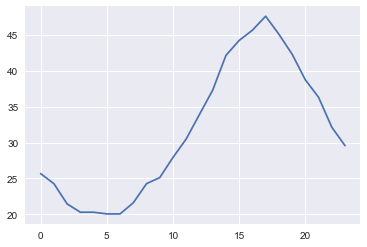

In [908]:
pred_ada = model.predict(input_p.values)
plt.plot(pred_ada)

In [909]:
RMSE = get_rmse(df['2017-08-16']['DAENERGY'], pred_ada)

In [910]:
RMSE

1.9742692617039523

In [918]:
input_p.columns.values[np.argsort(model.feature_importances_)[::-1]]

array(['LOAD', 'daybefore', 'KDSM', 'KCMI', 'KLRD', 'KTEB', 'KDEC', 'KIND',
       'KMLI', 'KELP', 'KBAZ', 'hourofday', 'KSAT', 'KGRB', 'KAMA',
       'OUTAGE', 'KSTL', 'KINK', 'KDAY', 'KDTW', 'KFAR', 'KUES', 'KSGF',
       'CYWG', 'ISOWIND', 'HOUROFWEEK', 'KJCT', 'KODO', 'KAWM', 'KFWA',
       'KGWO', 'KCLE', 'KDET', 'KMSP', 'KGFK', 'KATT', 'KDFW', 'KUNV',
       'KCVG', 'KDAL', 'KCRW', 'KCRP', 'KCOU', 'KVCT', 'KCMH', 'KDBQ',
       'KROA', 'KDCA', 'KTYR', 'KDLH', 'KDMH', 'KDOV', 'KTTN', 'KDTO',
       'KTOL', 'KELD', 'KSUX', 'KCLL', 'KCID', 'KCKB', 'KARB', 'KZZV',
       'K2G4', 'KABE', 'KABI', 'KACT', 'KACY', 'KADS', 'KAKR', 'KYNG',
       'KANJ', 'KAOO', 'KARR', 'KESF', 'KAUS', 'KAVP', 'KWRI', 'KBIS',
       'KBPT', 'KBRO', 'KBTR', 'KBWI', 'KCAK', 'KCGI', 'KCGX', 'KERI',
       'KFDK', 'KEVV', 'KMSN', 'KLYH', 'KMAF', 'KMCI', 'KMDT', 'KMDW',
       'KMGW', 'KMKE', 'KMKG', 'KSBN', 'KMLU', 'KMRB', 'KMSY', 'KEWR',
       'KMWL', 'KORD', 'KORF', 'KOXB', 'KPHL', 'KPIA', 'KPIT', 'KPRX',
 

In [917]:
input_p.columns.values

array(['HOUROFWEEK', 'CYWG', 'K2G4', 'KABE', 'KABI', 'KACT', 'KACY',
       'KADS', 'KAKR', 'KAMA', 'KANJ', 'KAOO', 'KARB', 'KARR', 'KATT',
       'KAUS', 'KAVP', 'KAWM', 'KBAZ', 'KBIS', 'KBPT', 'KBRO', 'KBTR',
       'KBWI', 'KCAK', 'KCGI', 'KCGX', 'KCID', 'KCKB', 'KCLE', 'KCLL',
       'KCMH', 'KCMI', 'KCOU', 'KCRP', 'KCRW', 'KCVG', 'KDAL', 'KDAY',
       'KDBQ', 'KDCA', 'KDEC', 'KDET', 'KDFW', 'KDLH', 'KDMH', 'KDOV',
       'KDSM', 'KDTO', 'KDTW', 'KELD', 'KELP', 'KERI', 'KESF', 'KEVV',
       'KEWR', 'KFAR', 'KFDK', 'KFSD', 'KFST', 'KFWA', 'KGAI', 'KGFK',
       'KGLS', 'KGRB', 'KGRR', 'KGWO', 'KHGR', 'KHOU', 'KHZL', 'KIAD',
       'KIAH', 'KILG', 'KIND', 'KINK', 'KINL', 'KIPT', 'KJAN', 'KJCT',
       'KLAN', 'KLBB', 'KLCH', 'KLFK', 'KLIT', 'KLNS', 'KLRD', 'KLUK',
       'KLYH', 'KMAF', 'KMCI', 'KMDT', 'KMDW', 'KMGW', 'KMKE', 'KMKG',
       'KMLI', 'KMLU', 'KMRB', 'KMSN', 'KMSP', 'KMSY', 'KMWL', 'KODO',
       'KORD', 'KORF', 'KOXB', 'KPHL', 'KPIA', 'KPIT', 'KPRX', 'KRDG',
       '